In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

In [4]:
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2024-10-29 21:10:21--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:3a::100:33a, 2001:1458:d00:3b::100:200, 2001:1458:d00:9::100:195, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:3a::100:33a|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357,67M  18,4MB/s    in 19s     

2024-10-29 21:10:41 (18,4 MB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [2]:
#%% load model and image
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "mps"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()


/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
count_parameters(medsam_model)

93735472

In [41]:
from pathlib import Path

from PIL import Image

base_tile_pth = Path("/Users/tsakalis/ntua/nestor/nestor_celvia/src/tiles/")

base_msk_pth = Path(
    "/Users/tsakalis/ntua/nestor/nestor_celvia/src/binary_masks/")
sample_id = "9c9e1e7d-d651-4e24-a15b-019e720da792"

In [6]:
msk_3c = np.array(Image.open(base_msk_pth / f"{sample_id}/6_436.jpeg"))

In [7]:
for img_pth in (base_tile_pth / sample_id).glob('*.jpeg'):
    img_3c = np.array(Image.open(img_pth))
    break

In [44]:
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class SampleGroupedDataset(Dataset):

    def __init__(self, base_tile_path, sample_ids, transform=None):
        self.samples = []
        self.transform = transform

        # Collect images grouped by sample directory
        for sample_id in sample_ids:

            sample_path = base_tile_path / sample_id
            image_paths = list(sample_path.glob('*.jpeg'))[:3]
            if image_paths:
                self.samples.append((sample_id, image_paths))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx][0]
        image_paths = self.samples[idx][1]

        images = []
        for img_path in image_paths:
            img_3c = np.array(Image.open(img_path))
            if self.transform:
                img_3c = self.transform(img_3c)
            img_tensor = torch.tensor(img_3c, dtype=torch.float32).permute(
                2, 0, 1)  # (C, H, W)
            images.append(img_tensor)
        image_tensor = torch.stack(images)

        return sample_id, image_tensor


# Parameters
# base_tile_path = Path('/path/to/base/tile')


In [46]:
sample_ids = [sample_id]  # list of subdirectories to include
batch_size = 1024  # Number of images per batch

# Create dataset and dataloader
dataset = SampleGroupedDataset(base_tile_pth, sample_ids, transform=None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Usage example
for batch in dataloader:
    # Each batch is a tensor of shape (batch_size, C, H, W)
    # batch = batch.squeeze(0)
    with torch.no_grad():
        sample_id_, batch_tensor = batch
        batch_tensor = batch_tensor.squeeze(0)
        image_embedding = medsam_model.image_encoder(batch_tensor.to(device))
    break

NameError: name 'medsam_model' is not defined

In [36]:
batch

[('9c9e1e7d-d651-4e24-a15b-019e720da792',),
 tensor([[[[[ 47.,  46.,  45.,  ..., 216., 222., 219.],
            [ 38.,  38.,  38.,  ..., 222., 224., 224.],
            [ 31.,  28.,  28.,  ..., 222., 226., 225.],
            ...,
            [ 41.,  41.,  41.,  ..., 221., 224., 226.],
            [ 40.,  40.,  41.,  ..., 227., 228., 229.],
            [ 41.,  41.,  41.,  ..., 230., 231., 231.]],
 
           [[ 36.,  35.,  36.,  ..., 174., 185., 187.],
            [ 27.,  27.,  27.,  ..., 180., 192., 194.],
            [ 18.,  18.,  18.,  ..., 184., 197., 200.],
            ...,
            [ 19.,  19.,  19.,  ..., 200., 203., 205.],
            [ 19.,  19.,  19.,  ..., 204., 205., 206.],
            [ 20.,  20.,  19.,  ..., 207., 206., 206.]],
 
           [[ 94.,  93.,  93.,  ..., 184., 192., 190.],
            [ 83.,  83.,  83.,  ..., 190., 197., 196.],
            [ 71.,  70.,  71.,  ..., 195., 202., 203.],
            ...,
            [ 58.,  58.,  58.,  ..., 215., 218., 220.],
   

In [14]:
256 * 64 * 64

1048576

In [15]:
import torch.nn as nn
# pool of square window of size=3, stride=2
m = nn.AvgPool2d(16, stride=10)
# pool of non-square window

input = torch.randn(20, 256, 64, 64)
output = m(input)

In [56]:
nn.AvgPool3d

torch.nn.modules.pooling.AvgPool3d

In [19]:
400 * 256 * 5 * 5

2560000

In [16]:
output.shape

torch.Size([20, 256, 5, 5])

In [45]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=100)

In [16]:
image_embedding.shape

torch.Size([3, 256, 64, 64])

In [15]:
pca.fit_transform(image_embedding.to('cpu').numpy())

ValueError: Found array with dim 4. PCA expected <= 2.

In [ ]:
image_embedding.shape

In [13]:
img_1024 = transform.resize(img_3c, (1024, 1024),
                            order=3,
                            preserve_range=True,
                            anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8,
    a_max=None)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(
    2, 0, 1).unsqueeze(0).to(device)


In [177]:
H, W, _ = img_3c.shape

In [301]:
box_np = np.array([[0, 0, 1024, 1024]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(
        img_1024_tensor)  # (1, 256, 64, 64)


In [329]:
random_points_pos = np.argwhere(msk_3c == 255)[np.random.randint(
    (688083), size=1000), :]

input_point_pos = torch.tensor(random_points_pos).unsqueeze(0).to(device)

input_label_pos = torch.tensor(np.array([input_point_pos.shape[1] * [1]
                                         ])).to(device)  # Shape: (1, 2)

random_points_neg = np.argwhere(msk_3c == 0)[np.random.randint(
    (199193), size=1000), :]

input_point_neg = torch.tensor(random_points_neg).unsqueeze(0).to(device)

input_label_neg = torch.tensor(np.array([input_point_pos.shape[1] * [0]
                                         ])).to(device)  # Shape: (1, 2)


In [336]:
input_point_neg.shape

torch.Size([1, 1000, 2])

In [340]:
torch.hstack([input_point_pos, input_point_neg])

torch.Size([1, 2000, 2])

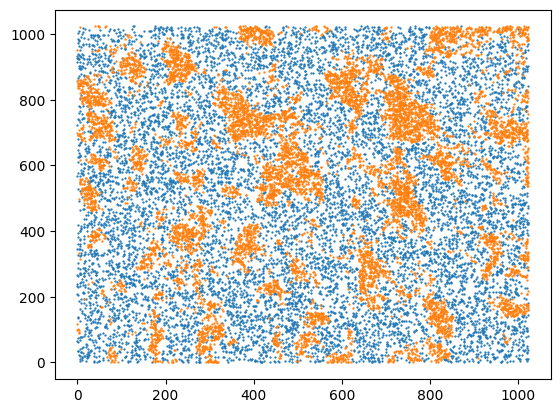

In [322]:
plt.scatter(input_point_pos[:, :, 0].cpu(),
            input_point_pos[:, :, 1].cpu(),
            s=0.4)

plt.scatter(input_point_neg[:, :, 0].cpu(),
            input_point_neg[:, :, 1].cpu(),
            s=0.4)

In [319]:
input_label.shape

torch.Size([1, 100])

In [320]:
input_point.shape

torch.Size([1, 100, 2])

In [271]:
@torch.no_grad()
def medsam_inference(medsam_model,
                     img_embed,
                     H,
                     W,
                     box=None,
                     points=None,
                     masks=None):

    if box:
        box_torch = torch.as_tensor(box,
                                    dtype=torch.float,
                                    device=img_embed.device)

        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=points,
        boxes=box,
        masks=masks,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(
        ),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [281]:
mask_tensor = torch.tensor(msk_3c).unsqueeze(0).unsqueeze(0).float().to(
    device) / 255

In [283]:
mask_tensor.shape

torch.Size([1, 1, 1024, 1024])

In [280]:
medsam_model.prompt_encoder


PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [341]:
medsam_seg = medsam_inference(
    medsam_model,
    image_embedding,
    H,
    W,
    points=(torch.hstack([input_point_pos, input_point_neg]),
            torch.hstack([input_label_pos, input_label_neg])))

(array([1009453.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   39123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

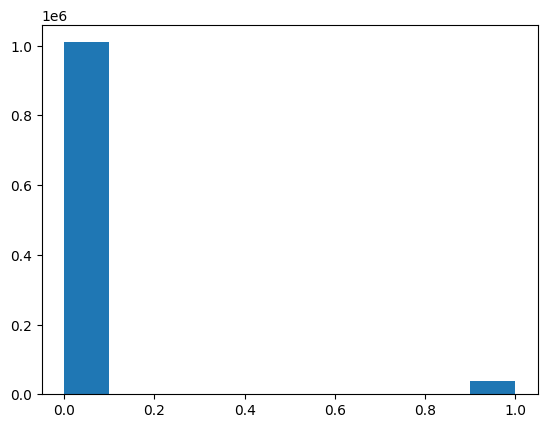

In [342]:
plt.hist(medsam_seg.flatten())

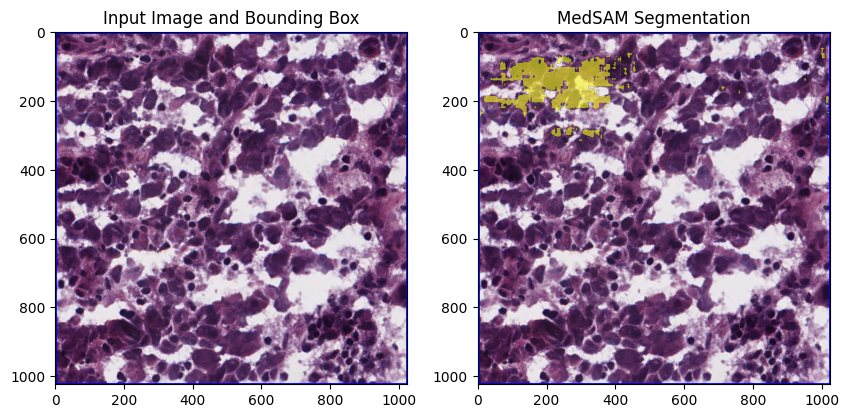

In [343]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_1024[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_1024[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()